Import libraries

In [1]:
import seaborn as sn
import pandas as pd
import json, os, io
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import time
import random

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from gensim.models import FastText

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant
from collections import OrderedDict
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from keras_preprocessing.text import tokenizer_from_json


Specify a constant seeder for processes

In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
def dropEmpty(tokens0):
    tokens = []
    for i in range(0, len(tokens0)):
        temp = tokens0[i]
        if temp != []:
            tokens.append(temp)
    return tokens

def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string 
    count = 0
    for ele in s: 
        if count==0:
            str1 = str1 + ele
        else:
            str1 = str1 + ' ' + ele
        count = count + 1
        #str1 += ele  
    
    # return string  
    return str1

def prepareData(data):
        
    # lowercase
    lines = []
    labels = []
    headlines = []
    for i in range(0, len(data)):
        labels.append(int(data[i][1]))
        headlines.append(data[i][0])
        line = data[i][2:]
        lows = [w.lower() for w in line]
        lines.append(lows)
    
    texts = []
    for i in range(0, len(lines)):
        texts.append(listToString(lines[i]))
    
    return texts, labels, headlines 

Read dataset

In [4]:
root_path = os.path.join('..', '..')
with open(os.path.join(root_path, 'data', 'dataset.csv'), newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = dropEmpty(data)

Shuffle dataset

In [5]:
random.shuffle(data)

In [6]:
texts, labels, headlines = prepareData(data)

Explore data

Elements in dataset: 4184
2 categories found:
0
1


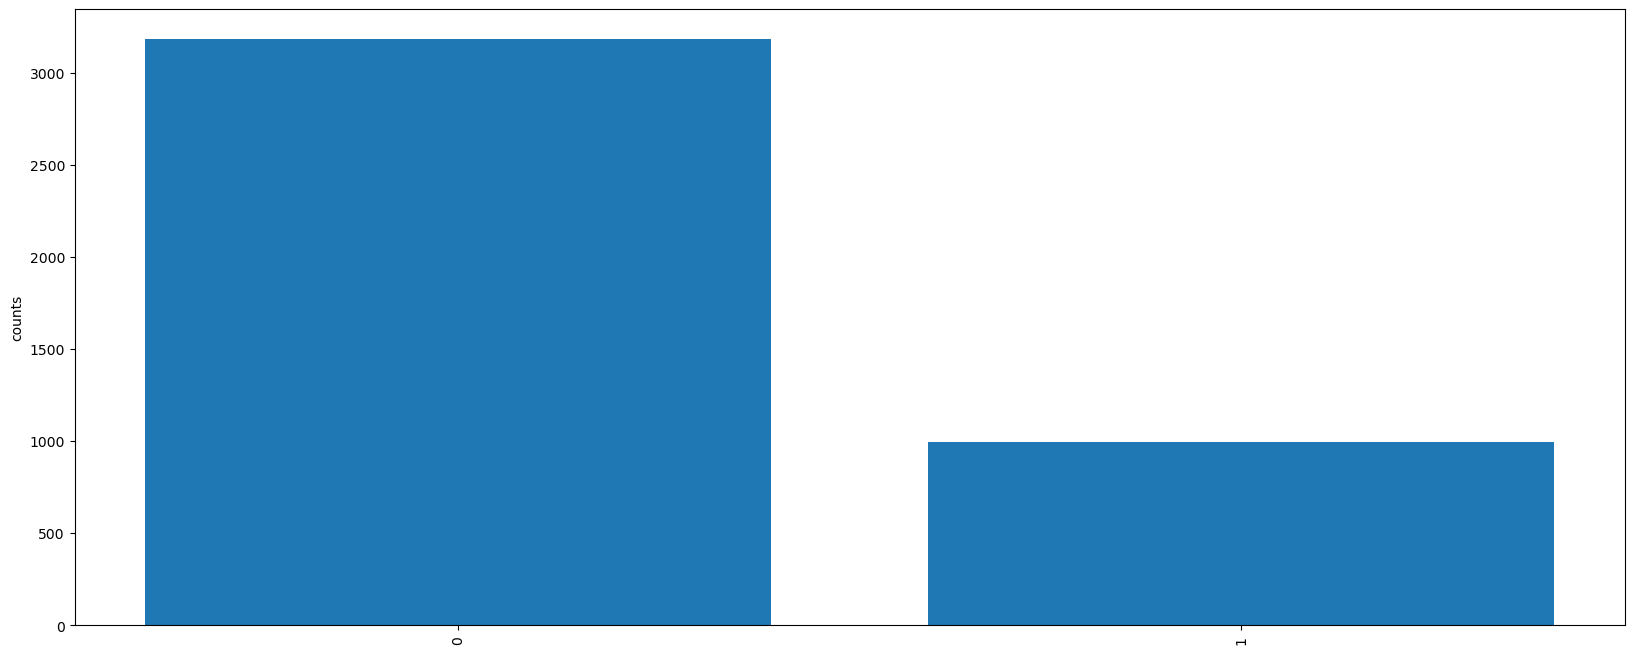

In [7]:
n_elements=len(headlines)
print('Elements in dataset:', n_elements)
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
print("{} categories found:".format(n_categories))
for category in categories:
    print(category)
    
fig=plt.figure(figsize=(20,8))
lbl, counts = np.unique(labels,return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks,lbl)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.show()

In [8]:
data = pd.DataFrame(({'Text': texts, 'Labels': labels}))
data.head()

,Text,Labels
0,class callbackmodule calls strid$ def __init__...,0
1,this_file os path abspath __file__ decode sys ...,0
2,class migration migrations migration dependenc...,0
3,dataset pd strid$ x dataset iloc numid$ values...,1
4,__metaclass__ type ansible_metadata strid$ str...,0


In [9]:
word_counts = data["Text"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
print("Maximum number of words per sequence:", max_length)

Maximum number of words per sequence: 510


In [10]:
label_frequencies = data['Labels'].value_counts()
print("Label Frequencies:\n", label_frequencies)
print("Total samples ", len(data))
n_categories = len(label_frequencies)
print("Number of classes:", n_categories)

Label Frequencies:
 Labels
0    3186
1     998
Name: count, dtype: int64
Total samples  4184
Number of classes: 2


Create word embedding vectors

In [11]:
def stringToList(string):
    codeLinesList = []
    for line in string.split():
        codeLinesList.append(line)
    return codeLinesList

allTokens = []
for seq in data["Text"]:
    listSeq = stringToList(seq)
    allTokens.append(listSeq)

data["Tokens"] = allTokens
#data["Tokens"][0]

In [12]:
# word embedding 
embeddings_index = {}
f = open('w2v_embeddings.txt', encoding="utf-8")
for line in f:    
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs   
f.close() 

dim = 200

In [13]:
tokenizer_obj = Tokenizer()   
tokenizer_obj.fit_on_texts(data["Tokens"])

tokenizer_json = tokenizer_obj.to_json()
tokenizerFile = 'w2v_tokenizer.json'

with io.open(tokenizerFile, 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

with open(tokenizerFile) as f:
    dataTokenizer = json.load(f)
    tokenizer_obj = tokenizer_from_json(dataTokenizer)

sequences = tokenizer_obj.texts_to_sequences(data["Tokens"])
word_index = tokenizer_obj.word_index

lines_pad = pad_sequences(sequences, padding = 'post', maxlen = max_length)

num_words = len(word_index) + 1 # +1 for the unknown-zeros

embedding_matrix = np.zeros((num_words, dim))
for word, i in word_index.items():
    if i > num_words:
        continue
    #embedding_vector = embeddings_index.get(word)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Split to train-val-test

In [14]:
val_ratio = 0.10

In [15]:
train_val_x, test_x, train_val_y, test_y = train_test_split(lines_pad, data['Labels'], test_size=val_ratio, random_state=seed, stratify=data['Labels'])
train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=val_ratio, random_state=seed, stratify=train_val_y)
# print(len(data))
# print(len(train_val_data))
# print(len(test_data))
# print(len(train_data))
# print(len(val_data))
# print(len(val_data)+len(train_data)+len(test_data))
# print(len(val_data)+len(train_data))

In [16]:
# rename
x_train = train_x
x_val = val_x
x_test = test_x

In [17]:
y_train = np.array(train_y)
y_val = np.array(val_y)
y_test = np.array(test_y)

Deep Learning Models

In [18]:
# Evaluation functions
def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

def f2_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f2 = 5*((prec*rec)/(4*prec+rec+K.epsilon()))
    return f2

In [19]:
  
def buildLstm(max_len, top_words, dim, optimizer, seed, embedding_matrix, multi, n_outputs):
    model=Sequential()
    #model.add(Embedding(input_dim=top_words+1, output_dim=dim, input_length=None, mask_zero=True))
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    #model.add(SimpleRNN(300, dropout=0.3, stateful=False))
    model.add(LSTM(100, dropout=0.2, return_sequences=True, stateful=False))
    model.add(LSTM(50, dropout=0.1, stateful=False))
    #model.add(Bidirectional(LSTM(300, dropout=0.3, stateful=False)))
    #model.add(GRU(300, dropout=0.3, stateful=False))
    model.add(Activation('relu')) #dropout=0.2, recurrent_dropout=0.2, kernel_constraint=max_norm(3), bias_constraint=max_norm(3)
    model.add(BatchNormalization())
    if multi == False:
        model.add(Dense(n_outputs, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_metric])  
    else: 
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
    return model

In [20]:
# hyperparams
n_epoch = 100
batch_size = 128
optimizer = 'adam'
patience = 10

Train model

In [21]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

myModel = buildLstm(max_length, num_words, dim, optimizer, seed, embedding_matrix, False, 1)
print("model summary\m",myModel.summary())

csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=1, patience=patience)
mc = ModelCheckpoint('best_model.h5', monitor='val_f1_metric', mode='max', verbose=1, save_best_only=True)

history = myModel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = n_epoch, batch_size = batch_size, verbose=1, callbacks=[csv_logger,es,mc])

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)

Training...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2136600   
                                                                 
 lstm (LSTM)                 (None, None, 100)         120400    
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 batch_normalization (BatchN  (None, 50)               200       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 51        
                                            

Load best model

In [22]:
myModel.load_weights("best_model.h5")

Make predictions on the testing set and compute evaluation metrics

In [23]:
predScores = myModel.predict(x_test)
predictions = (predScores > 0.5).astype("int32")

print(classification_report(y_test, predictions))

14/14 [==============================] - 3s 87ms/step
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       319
           1       0.69      0.68      0.69       100

    accuracy                           0.85       419
   macro avg       0.80      0.79      0.79       419
weighted avg       0.85      0.85      0.85       419



TP= 68
TN= 289
FP= 30
FN= 32
Accuracy:85.20%
Precision:69.39%
Recall:68.00%
Roc_Auc score:79.30%
F1 score:68.69%
F2 score:68.27%


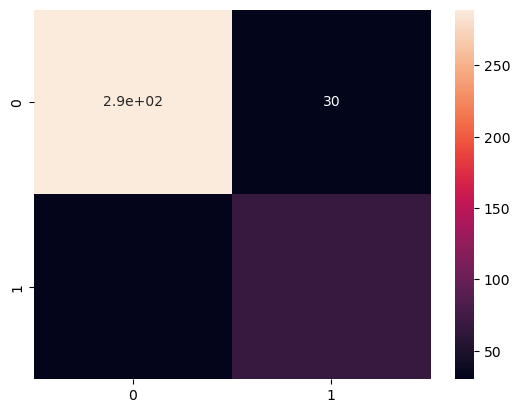

In [24]:
accuracy=accuracy_score(y_test, predictions)
precision=precision_score(y_test, predictions)
recall=recall_score(y_test, predictions)
roc_auc=roc_auc_score(y_test, predictions)
f1=f1_score(y_test, predictions)
f2 = (5*precision*recall) / (4*precision+recall)

conf_matrix = confusion_matrix(y_test, predictions)
sn.heatmap(conf_matrix, annot=True)

tn, fp, fn, tp = conf_matrix.ravel()
acc = ((tp+tn)/(tp+tn+fp+fn))
print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F1 score:%.2f%%"%(f1*100))
print("F2 score:%.2f%%"%(f2*100))